In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

In [2]:
train = pd.read_csv("./exercise_40_train.csv")
test = pd.read_csv("./exercise_40_test.csv")

Now apply all preprocessing modifications to train and test data

In [3]:
# change 'x7' and 'x19' to continuous variables
train['x7'] = train.x7.str.replace("%",'').astype(np.float64)
test['x7'] = test.x7.str.replace("%",'').astype(np.float64)
train['x19'] = train.x19.str.replace("$",'').astype(np.float64)
test['x19'] = test.x19.str.replace("$",'').astype(np.float64)

# drop column 'x39'
train.drop('x39',axis=1,inplace=True)
test.drop('x39',axis=1,inplace=True)

# 'x99': missing data gets its own category
train["x99"] = train["x99"].fillna("U")
test["x99"] = test["x99"].fillna("U")

# 'x3': Set consistent naming convention for days of the week
train['x3'] = train['x3'].str[:3]
test['x3'] = test['x3'].str[:3]

# 'x60': Sort Months into "Summer" and "Winter"
month_map = {
        "February":"FebMarApr",
        "March":"FebMarApr",
        "April":"FebMarApr",
        "May":"MayJun",
        "June":"MayJun",
        "September":"SepOctNov",
        "October":"SepOctNov",
        "November":"SepOctNov"
    }
train["x60"] = train['x60'].replace(month_map)
test["x60"] = test['x60'].replace(month_map)

# 'x24': treat missing data as its own category
train["x24"] = train["x24"].fillna("U")
test["x24"] = test["x24"].fillna("U")

# Group states into VeryHigh, High, Medium, Low, and VeryLow risk
df = train[["x33","y"]].groupby(by='x33',dropna=False).agg(['mean','count'])
df["bin"] = pd.cut(df[("y","mean")], bins=[.03,.105,.13,.16,.19,.34], labels=["VeryLow","Low","Medium","High","VeryHigh"] )
state_map = {}
for index, row in df.iterrows():
    state_map[index] = row.bin.iloc[0]
train['x33'] = train['x33'].replace(state_map)
test['x33'] = test['x33'].replace(state_map)

# 'x77': combine 'toyota', 'buick', 'nissan' into single category.
train['x77'] = train["x77"].replace({"toyota":"ToyotaNissanBuick",
                                    "nissan":"ToyotaNissanBuick",
                                    "buick":"ToyotaNissanBuick"})
test['x77'] = test["x77"].replace({"toyota":"ToyotaNissanBuick",
                                    "nissan":"ToyotaNissanBuick",
                                    "buick":"ToyotaNissanBuick"})
# 'x77': treat missing data as its own category
train["x77"] = train["x77"].fillna("U")
test["x77"] = test["x77"].fillna("U")   

Now, standardize all continuous features of training data and use this scale for the testing data. Then fill training and testing NaN's with the meidan value for training data.

In [4]:
train_cat = train.loc[:,train.dtypes==np.object].copy()
test_cat = test.loc[:,train.dtypes==np.object].copy()
train_num = train.loc[:,train.dtypes==np.float64].copy()
test_num = test.loc[:,train.dtypes==np.float64].copy()
y_train = train.y.copy()

# normalize all continuous data
scaler = StandardScaler()
scaler.fit(train_num)
train_num_scal = scaler.transform(train_num)
test_num_scal = scaler.transform(test_num)

# fill in all missing continuous data with median of training data
imputer = SimpleImputer(strategy='median')
imputer.fit(train_num_scal)
train_num_scal_tf = pd.DataFrame( imputer.transform(train_num_scal), 
                                 columns = train_num.columns, index = train_num.index )
test_num_scal_tf = pd.DataFrame( imputer.transform(test_num_scal), 
                                 columns = test_num.columns, index = test_num.index )

# get dummy variables
cat_var_ls = [
    'x3_Mon','x3_Tue','x3_Thu','x3_Fri','x3_Sat','x3_Sun',#'x3_Wed',
    'x24_male','x24_U',#'x24_female',
    'x31_yes',#'x31_no',
    'x33_VeryLow','x33_Medium','x33_High','x33_VeryHigh',#'x33_Low',
    'x60_January','x60_FebMarApr','x60_MayJun','x60_July','x60_August','x60_SepOctNov',#'x60_December',
    'x65_allstate', 'x65_esurance', 'x65_farmers','x65_geico',#'x65_progressive'
    'x77_ford','x77_subaru','x77_mercedes','x77_chevrolet','x77_ToyotaNissanBuick',#'x77_U',
    'x93_yes',#'x93_no',
    'x99_U',#'x99_yes',
]
train_cat_dum = pd.get_dummies(train_cat)[cat_var_ls]
test_cat_dum = pd.get_dummies(test_cat)[cat_var_ls]

X_train = pd.concat([train_num_scal_tf,train_cat_dum], axis=1)
X_test = pd.concat([test_num_scal_tf,test_cat_dum], axis=1)

# Generalized Linear Model

In [5]:
# get the features selected by RFECV
glm_rfe = RFECV( LogisticRegression(max_iter=10000),cv=10, scoring='roc_auc',n_jobs=-1)
glm_rfe.fit(X_train,y_train)
features = X_train.columns[glm_rfe.support_]
# fit logistic regression to training data with the selected features
glm = LogisticRegression(max_iter=10000)
glm.fit(X_train[features],y_train)
# predict probabilities for testing data
test_preds_glm = glm.predict_proba(X_test[features])[:,1]
pd.DataFrame(test_preds_glm).to_csv("./glmresults.csv",index=False,header=False)

# AdaBoost

For AdaBoost model, encode 'x33' as an ordinal categorical feature.

In [6]:
x33_categories = ["VeryLow","Low","Medium","High","VeryHigh"]
enc = OrdinalEncoder(categories = [x33_categories])
X_train_rf = X_train.drop(["x33_VeryLow","x33_Medium","x33_High","x33_VeryHigh"],axis=1)
X_test_rf = X_test.drop(["x33_VeryLow","x33_Medium","x33_High","x33_VeryHigh"],axis=1)
# create ordinal column for different states
X_train_rf["x33"] = enc.fit_transform(train.x33.to_numpy().reshape(-1,1)).reshape(1,-1)[0]
X_test_rf["x33"] = enc.fit_transform(test.x33.to_numpy().reshape(-1,1)).reshape(1,-1)[0]

In [7]:
ada = AdaBoostClassifier(algorithm="SAMME.R",learning_rate=0.1,n_estimators=750)
ada.fit(X_train_rf,y_train)
test_preds_ada = ada.predict_proba(X_test_rf)[:,1]
pd.DataFrame(test_preds_ada).to_csv("./nonglmresults.csv",index=False,header=False)

## Model Comparison

To compare the performance of the different models, in addition to their performance by ROC-AUC score, we'll generate their confusion matrix on *training* data. It would be slightly more accurate to compare the confusion matrices on a test or validation set.

In [8]:
from sklearn.metrics import confusion_matrix

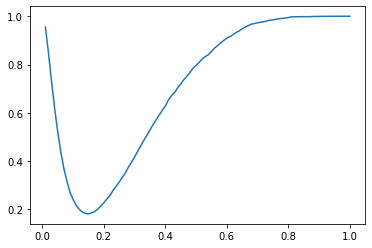

In [10]:
# total number of observations in positive class
pos = sum(y_train)
# number of observations in negative class
neg = sum(y_train==0)
thresholds = np.linspace(0.01,1,100)
sse = np.zeros(len(thresholds))
for i in range(len(thresholds)):
    tn, fp, fn, tn = confusion_matrix(y_train, glm.predict_proba(X_train[features])[:,1]>thresholds[i]).ravel()
    # minimize sum-squared false positive rate (FPR) and false negative rate (FNR)
    sse[i] = fp**2/neg**2 + fn**2/pos**2

plt.figure()
plt.plot(thresholds, sse)
plt.show()

In [11]:
# identify index of best threshold and display resulting confusion matrix
idx = np.argmin(sse)
thr = thresholds[idx]
confusion_matrix(y_train,glm.predict_proba(X_train[features])[:,1]>thr)

array([[24003, 10194],
       [ 1768,  4035]], dtype=int64)

Now do the same for the AdaBoost model:

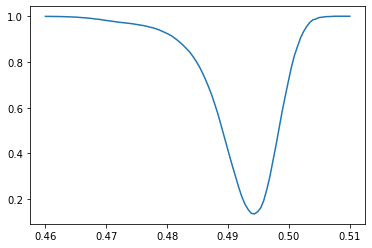

In [12]:
# the AdaBoost probabilities are all between .45 and .51, focus thresholds in this range
thresholds = np.linspace(0.46,.51,100)
sse = np.zeros(len(thresholds))
for i in range(len(thresholds)):
    tn, fp, fn, tn = confusion_matrix(y_train, ada.predict_proba(X_train_rf)[:,1]>thresholds[i]).ravel()
    sse[i] = fp**2/neg**2 + fn**2/pos**2

plt.figure()
plt.plot(thresholds, sse)
plt.show()

In [13]:
idx = np.argmin(sse)
thr = thresholds[idx]
confusion_matrix(y_train,ada.predict_proba(X_train_rf)[:,1]>thr)

array([[25235,  8962],
       [ 1504,  4299]], dtype=int64)